In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
from shapely.geometry import LineString, Point
import networkx as nx
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from dijkstra_path_prediction import DijkstraPathPrediction

In [3]:
# Load a model from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_date = '202205'
test_date = '202206'
DP_tol = 10
min_samples = 13

model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [4]:
# Load training data from file
filename = model_name+'_'+train_date+'training_data.csv'
training_data = pd.read_csv('../../data/train_test/'+filename)
training_data['path'] = training_data['path'].apply(literal_eval)
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.GeoSeries.from_wkt(training_data['geometry']), crs='32632')

In [5]:
# Load test data from file
filename = model_name+'_'+test_date+'training_data.csv'
test_data = pd.read_csv('../../data/train_test/'+filename)
test_data['path'] = test_data['path'].apply(literal_eval)
test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs='32632')

# Load respective trajectories for evaluation
traj_file = test_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + traj_file + '.parquet'
traj_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
traj_gdf.to_crs(crs, inplace=True)  # Transformation
test_trajectories = mpd.TrajectoryCollection(traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [6]:
training_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unnamed: 0        1452 non-null   int64   
 1   mmsi              1452 non-null   object  
 2   SSPD              1452 non-null   float64 
 3   distances         1452 non-null   object  
 4   fraction_covered  1452 non-null   float64 
 5   message           1452 non-null   object  
 6   path              1452 non-null   object  
 7   path_linestring   1452 non-null   object  
 8   lengde            1452 non-null   int64   
 9   bredde            1056 non-null   float64 
 10  dypgaaende        957 non-null    float64 
 11  skipstype         1056 non-null   object  
 12  skipsgruppe       1056 non-null   object  
 13  geometry          1452 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(7)
memory usage: 158.9+ KB


In [7]:
# train model
model = DijkstraPathPrediction()
model.train(network.G_pruned, training_data['path'])

Evaluating model on 10 samples
Progress: 10%...20%...30%...40%...50%...Done!


Mean SSPD: 270.41m
Median SSPD: 152.34m


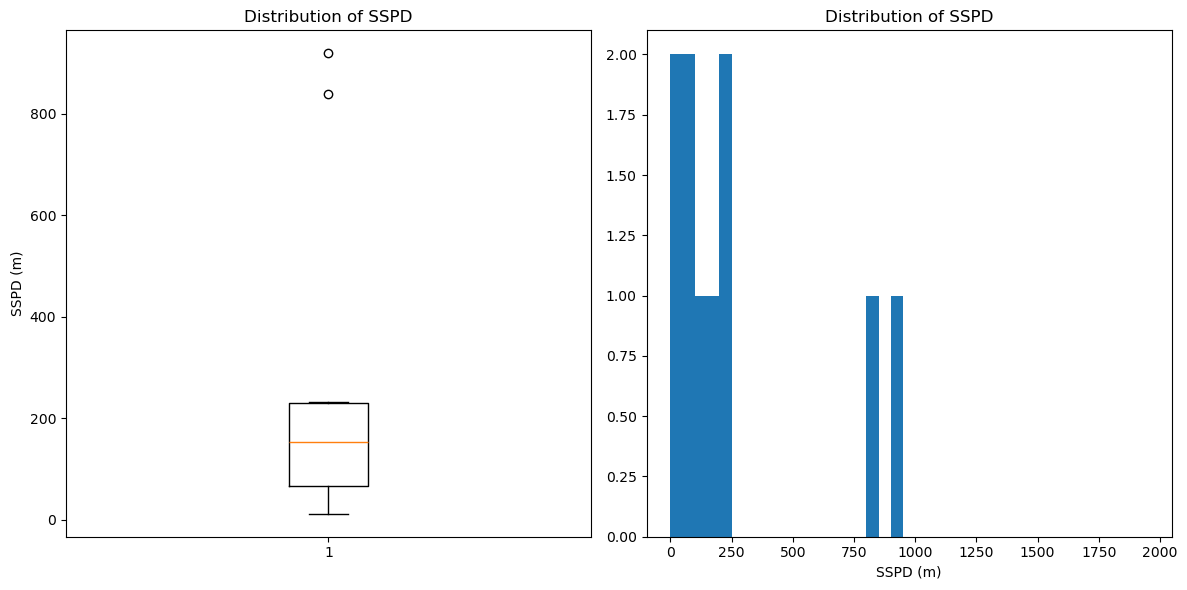

In [8]:
# evaluate model
selection = range(0, 10, 1)  # len(test_data)
test_paths = test_data.iloc[selection]
eval_results = model.evaluate(test_paths[['mmsi', 'path']], test_trajectories, network, eval_mode='trajectory')

In [9]:
eval_results

,mmsi,true_path,predicted_path,distances,SSPD
0,210055000_0_2022-06-01 09:31:46,"[130, 129, 128, 4, 350, 349, 323, 309, 455, 45...","[130, 129, 128, 4, 354, 353, 350, 349, 323, 31...","[102.64629040653435, 110.58567342360327, 114.9...",838.411504
0,210055000_8_2022-06-01 20:12:01,"[505, 484, 485, 486, 487, 475, 460, 461, 456, ...","[505, 502, 503, 484, 485, 486, 487, 475, 460, ...","[0.3817208132566751, 4.683139398206111, 0.8623...",76.043494
0,210189000_0_2022-06-24 06:55:42,"[185, 180, 179, 178, 224, 223, 204, 217, 247, ...","[185, 180, 179, 178, 224, 223, 236, 217, 247, ...","[52.8653567900906, 49.35383251565075, 40.67886...",223.774551
0,210189000_100_2022-06-30 09:45:31,"[466, 463, 462, 25, 449, 439, 425, 426, 429, 4...","[466, 463, 462, 25, 449, 439, 425, 426, 429, 4...","[7.0398506521261845, 7.083555601088871, 7.1278...",63.827614
0,210189000_8_2022-06-25 16:12:16,"[458, 467, 466, 463, 462, 25]","[458, 467, 466, 463, 462, 25]","[37.8666146118303, 30.18601215663123, 23.48998...",11.775031
0,210311000_1_2022-06-16 07:50:07,"[115, 106, 108, 72, 111, 112, 47]","[115, 106, 111, 47]","[133.32364545774297, 134.89352708063453, 140.2...",134.396409
0,211102000_0_2022-06-03 02:00:05,"[366, 352, 359, 374, 384, 375, 380, 364, 468]","[366, 365, 358, 357, 361, 352, 359, 374, 384, ...","[85.77108055210745, 103.02290689511483, 144.87...",232.821889
0,211102000_27_2022-06-12 22:36:30,"[313, 3, 356, 322, 326, 341, 342, 338, 345]","[313, 3, 348, 356, 363, 362, 333, 332, 328, 32...","[239.36250024072515, 239.82224865371415, 240.2...",170.275893
0,211102000_6_2022-06-03 20:10:17,"[465, 464]","[465, 464]","[42.734986499584, 25.563960057178413, 13.39449...",33.855858
0,211753000_0_2022-06-03 15:55:17,"[185, 180, 179, 204, 217, 247, 298, 295, 294, ...","[185, 180, 179, 178, 224, 223, 236, 217, 247, ...","[5.663784162724129, 1.1803140047496608, 2.3010...",918.944887


In [10]:
# load trajectories

In [12]:
# plot network and basemap
network.prune_graph(100)
map = network.map_graph(pruned=True, center=[69, 19], min_passages=3)  #tromso: center=[69, 19]

# plot prediction and ground truth
selection = [1, 2, 3, 4, 5]
for i in selection:
    mmsi = eval_results['mmsi'].iloc[i]
    predicted_path = eval_results['predicted_path'].iloc[i]
    true_path = eval_results['true_path'].iloc[i]
    true_path_line = geometry_utils.get_geo_df(true_path, network.waypoint_connections)
    predicted_path_line = geometry_utils.get_geo_df(predicted_path, network.waypoint_connections)
    predicted_path_line['SSPD'] = eval_results['SSPD'].iloc[i]
    trajectory = test_trajectories.get_trajectory(mmsi).to_line_gdf()

    map = trajectory[['mmsi', 'geometry', 'skipsgruppe', 'length', 'bredde']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1},
                                                                                      name=f'{mmsi} trajectory')
    map = true_path_line.explore(m=map, style_kwds={'weight':3, 'color':'cyan', 'opacity':1},
                               name=f'{mmsi} closest path')
    map = predicted_path_line.explore(m=map, style_kwds={'weight':3, 'color':'yellow', 'opacity':1},
                                   name=f'{mmsi} prediction')
    
folium.LayerControl().add_to(map)
map.save('../../reports/maps/'+model_name+'_predictions.html')

Pruning...
------------------------
Pruned Graph:
Number of nodes: 541 (1 isolated)
Number of edges: 1467
------------------------
